# NN draw

In [1]:
import jax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from jaxopt import ProjectedGradient

In [2]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_palette("colorblind")
colors = sns.color_palette()

## The model objective function

In [5]:
class TrueMLP(nn.Module):
    n_hidden: int = 50

    def setup(self):
        self.hidden_1 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.hidden_2 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.last = nn.Dense(1,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

    def __call__(self, x):
        x = self.hidden_1(x)
        x = nn.relu(x)
        x = self.hidden_2(x)
        x = nn.relu(x)
        x = self.last(x)
        return x

In [6]:
key = jax.random.PRNGKey(3141)
key_init, key_run = jax.random.split(key)

In [7]:
dim = 200 # change to 200
X_init = jnp.ones((1, dim))

base_model = TrueMLP()
params_base = base_model.init(key_init, X_init)

In [8]:
def objective_fn(x):
    return -base_model.apply(params_base, x)

In [9]:
def plot_hist(ax, runs, color=None, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    color_plot = "black" if color is None else color
    color_fill = "tab:gray" if color is None else color
    
    ax.plot(med_run, c=color_plot, **kwargs)
    ax.fill_between(steps, lbound, ubound, color=color_fill, alpha=0.4)

## Best optimum (projected gradient descent)

In [10]:
opt = ProjectedGradient(
    fun=lambda x: -base_model.apply(params_base, x).squeeze(),
    projection=partial(eval_fn.projection, lbound=0.0, ubound=1.0),  # Enforce boundary constraints
    stepsize=1e-7,
    maxiter=8000
)

guess_init = jax.random.uniform(key_run, dim) # intial guess per run
res = opt.run(init_params=guess_init)

In [11]:
yopt = base_model.apply(params_base, res.params)
yopt

Array([1765.5752], dtype=float32)

## Low-rank Kalman filter (LRKF)

In [530]:
agent, bel_init_fn = agents.load_lrkf_agent(
    X_init, rank=50, cov=1.0, obs_noise=0.1, dynamics_cov=1, low_rank_diag=False,
)

In [531]:
%%time
n_steps = 600
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
bel, runs_lrkf = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)

CPU times: user 788 ms, sys: 11.4 s, total: 12.2 s
Wall time: 8.68 s


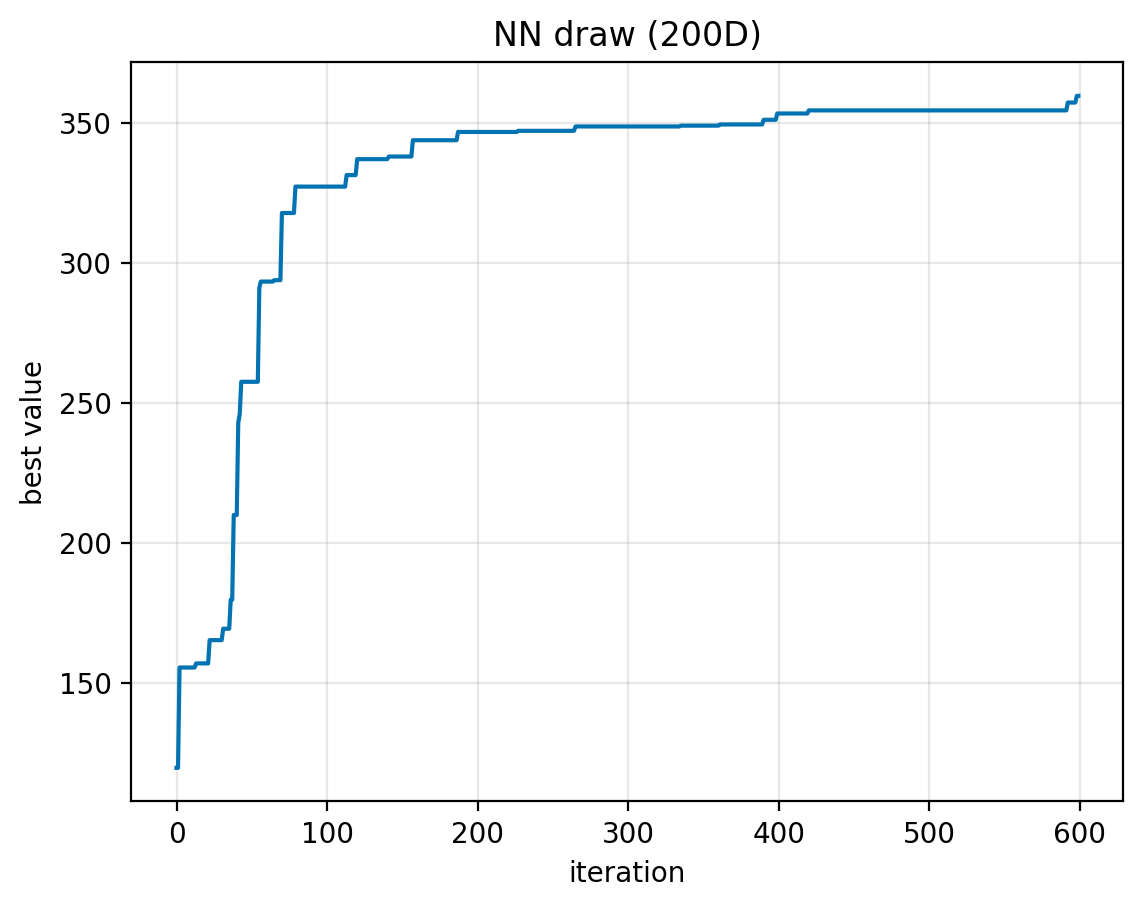

In [532]:
fig, ax = plt.subplots()
ax.plot(runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

CPU times: user 27.5 s, sys: 589 ms, total: 28 s
Wall time: 23.6 s


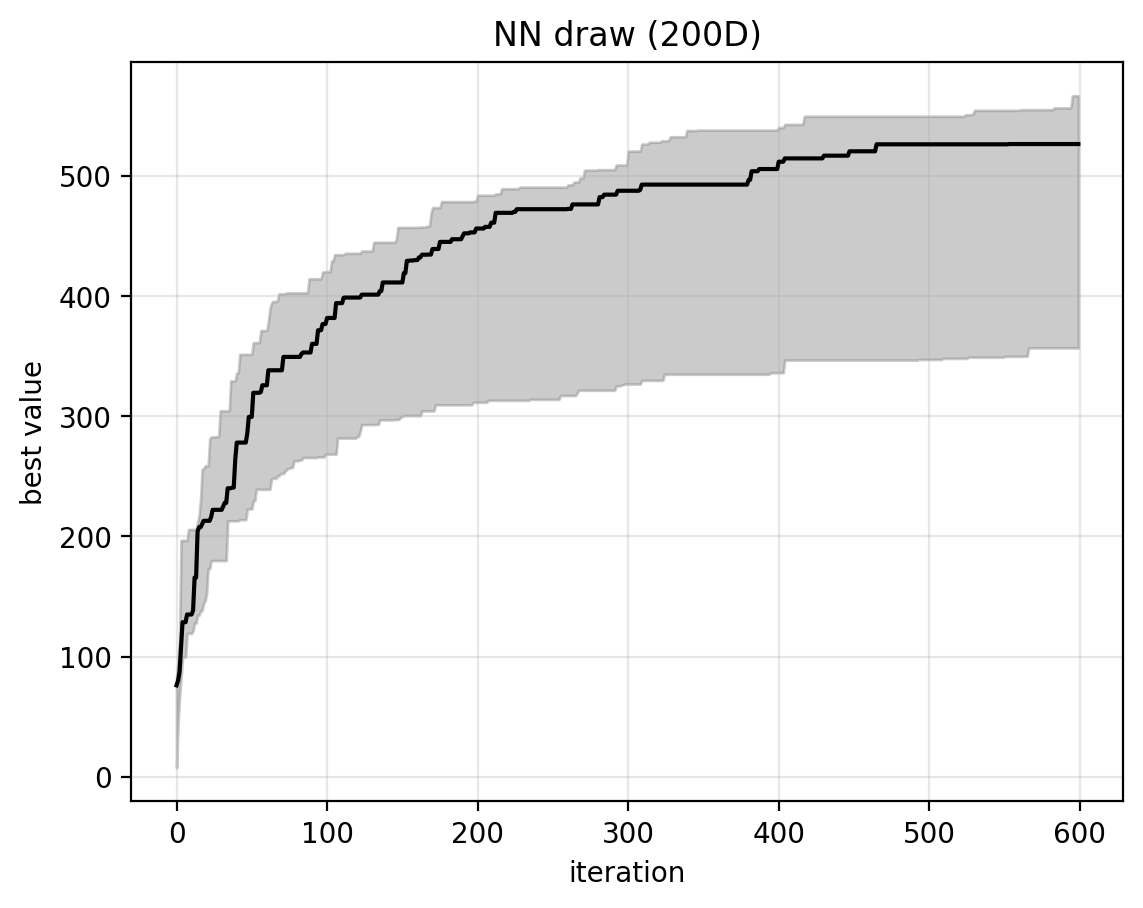

In [533]:
%%time
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_lrkf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
# runs_lrkf = jax.tree.map(np.array, runs_lrkf)

fig, ax = plt.subplots()
plot_hist(ax, runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## LL-LRKF

In [188]:
agent, bel_init_fn = agents.load_ll_lrkf_agent(
    X_init, rank=50, cov_hidden=1e-4, cov_last=0.01, dynamics_last=1e-6,
)

In [189]:
%%time
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_l3rkf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_l3rkf = jax.tree.map(np.array, runs_l3rkf)

CPU times: user 34.4 s, sys: 837 ms, total: 35.3 s
Wall time: 26 s


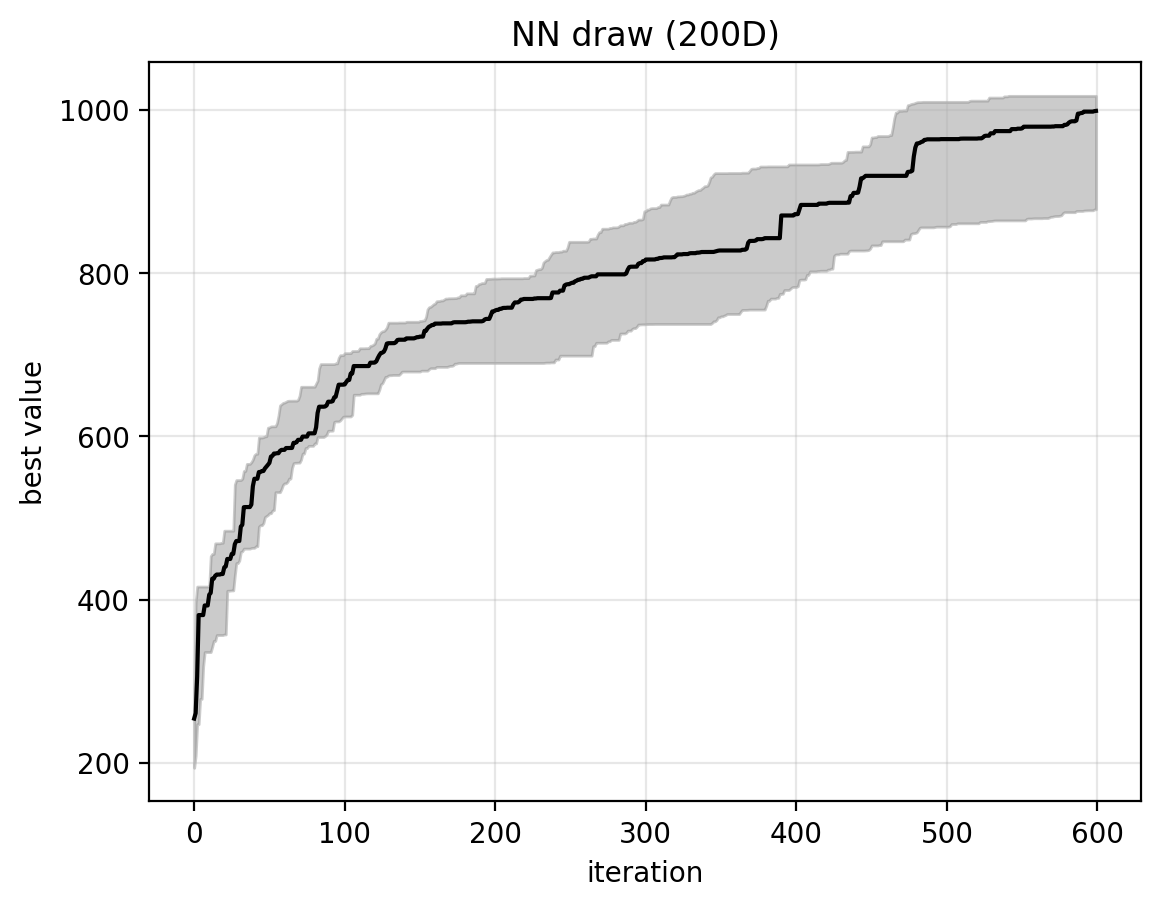

In [190]:
fig, ax = plt.subplots()
plot_hist(ax, runs_l3rkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Run multiple dims

In [210]:
%%time
ranks = [0, 1, 10, 50, 100, 150]
n_steps = 600
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
for rank in ranks:
    print(rank, end="\r")
    
    agent, bel_init_fn = agents.load_ll_lrkf_agent(
        key_init_params, X_init, rank=rank, cov_hidden=1e-4, cov_last=0.01,
    )    

    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
    runs = jax.tree.map(np.array, runs)
    runs_all[rank] = runs

CPU times: user 4min 34s, sys: 9.44 s, total: 4min 43s
Wall time: 3min 36s


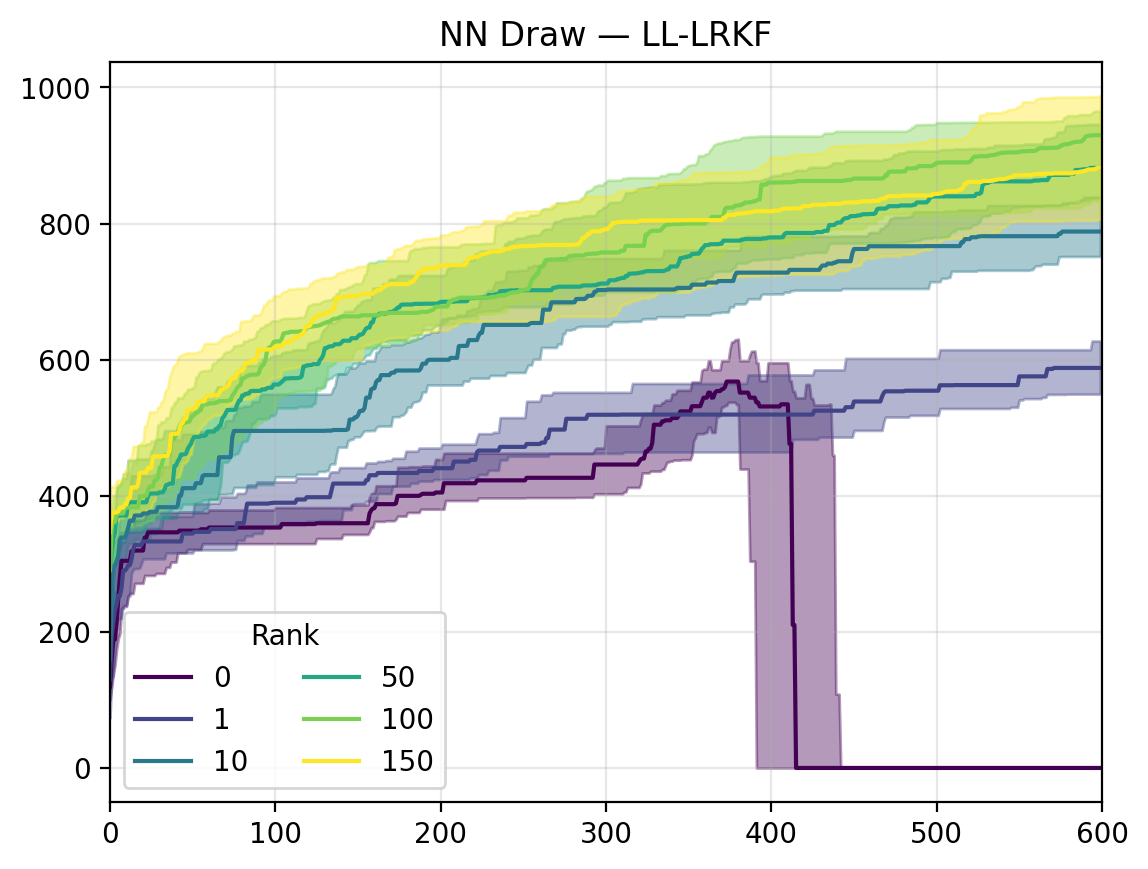

In [211]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, rank in zip(colors, ranks):
    plot_hist(ax, runs_all[rank]["y_best"], color=color, label=rank)
plt.legend(title="Rank", ncols=2)
# plt.ylim(bottom=800)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.grid(alpha=0.3)

## Run multiple noise terms

In [91]:
%%time

ll_cov_init = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
rank = 10
n_steps = 600
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
for cfg in ll_cov_init:
    print(cfg, end="\r")
    
    agent, bel_init_fn = agents.load_ll_lrkf_agent(
        X_init, rank=rank, cov_hidden=1e-4, cov_last=cfg,
    )    

    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
    runs = jax.tree.map(np.array, runs)
    runs_all[cfg] = runs

CPU times: user 4min 24s, sys: 26.7 s, total: 4min 50s
Wall time: 4min 6s


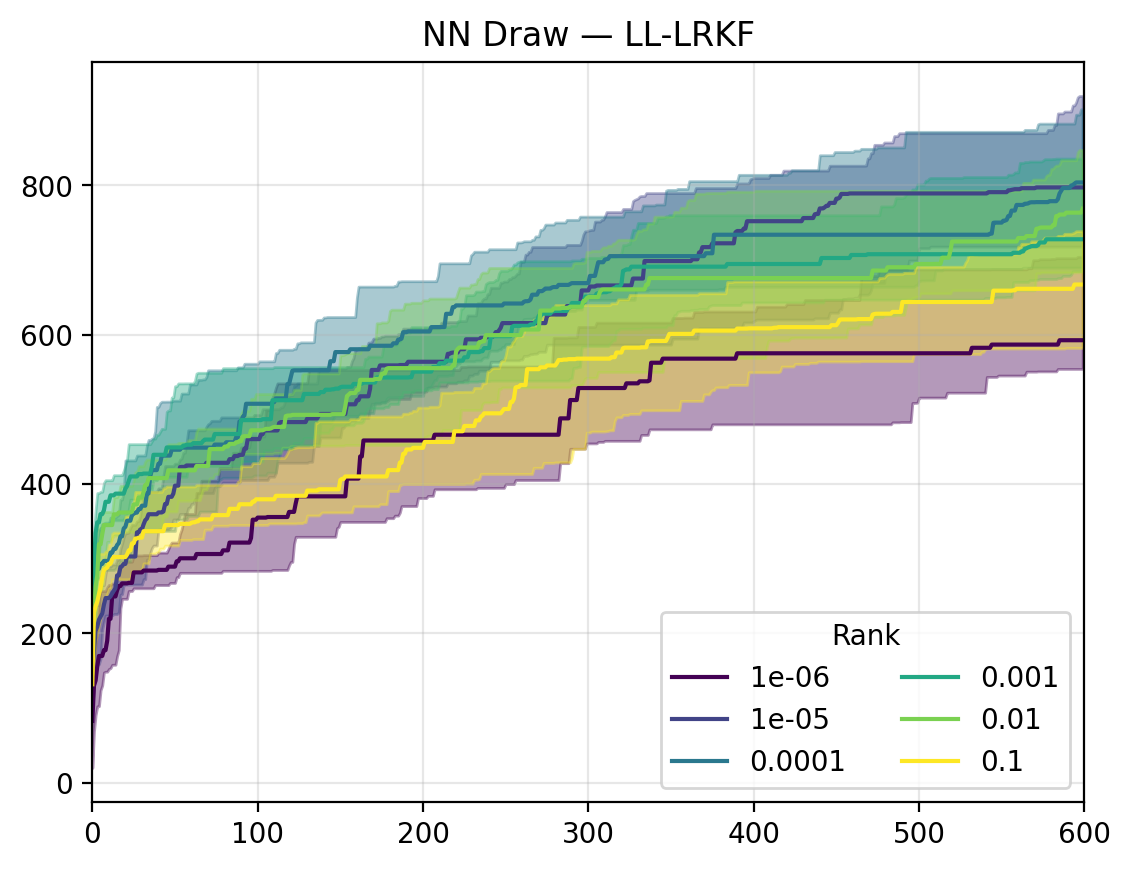

In [92]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, cfg in zip(colors, ll_cov_init):
    plot_hist(ax, runs_all[cfg]["y_best"], color=color, label=cfg)
plt.legend(title="Rank", ncols=2)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.grid(alpha=0.3)

## LoFi

In [389]:
rank = 50
agent, bel_init_fn = agents.load_lofi_agent(
    X_init, rank=rank, cov_init=1e-6, obs_noise=1.0, dynamics_covariance=1e-5
)

In [390]:
%%time
n_steps = 600
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
bel, runs_lrkf = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)

CPU times: user 25.4 s, sys: 1.13 s, total: 26.5 s
Wall time: 17.5 s


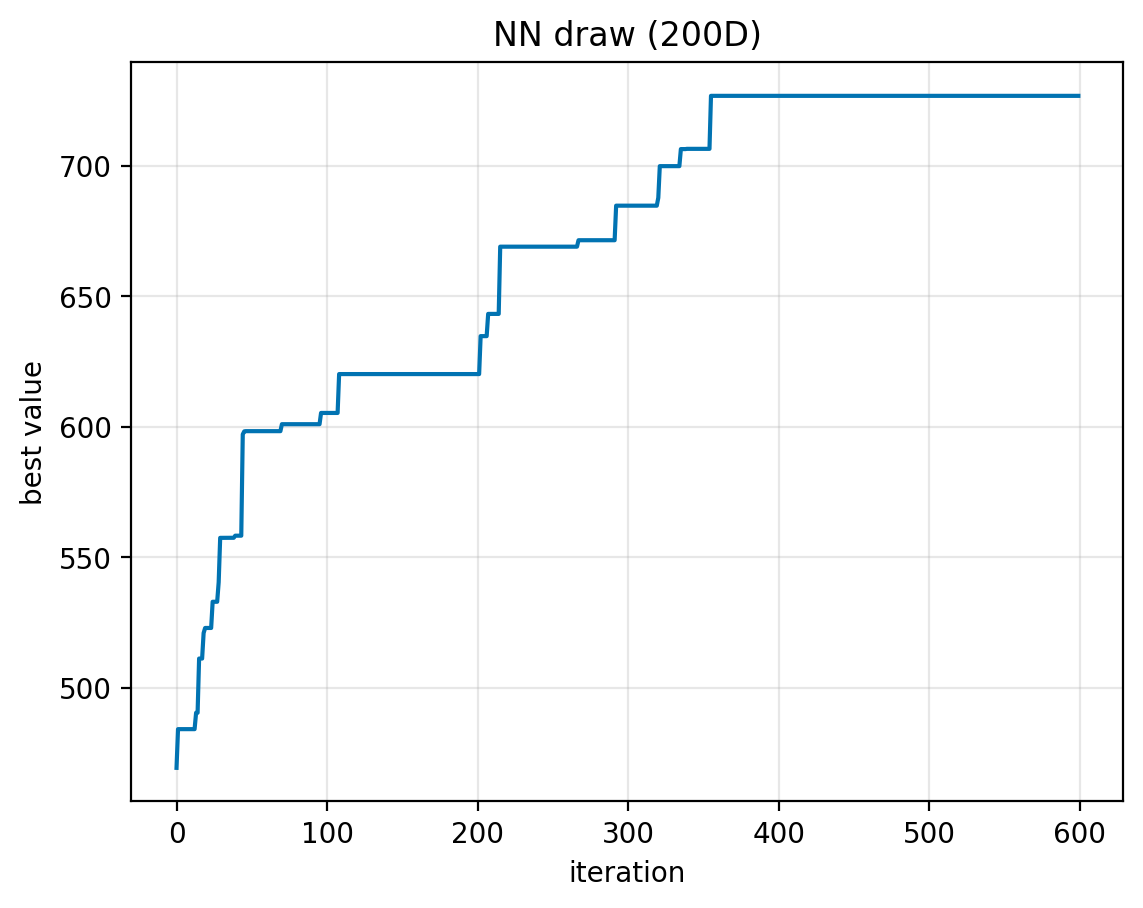

In [391]:
fig, ax = plt.subplots()
ax.plot(runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

In [392]:
%%time
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
runs = jax.tree.map(np.array, runs)

CPU times: user 42 s, sys: 2.49 s, total: 44.4 s
Wall time: 1min 37s


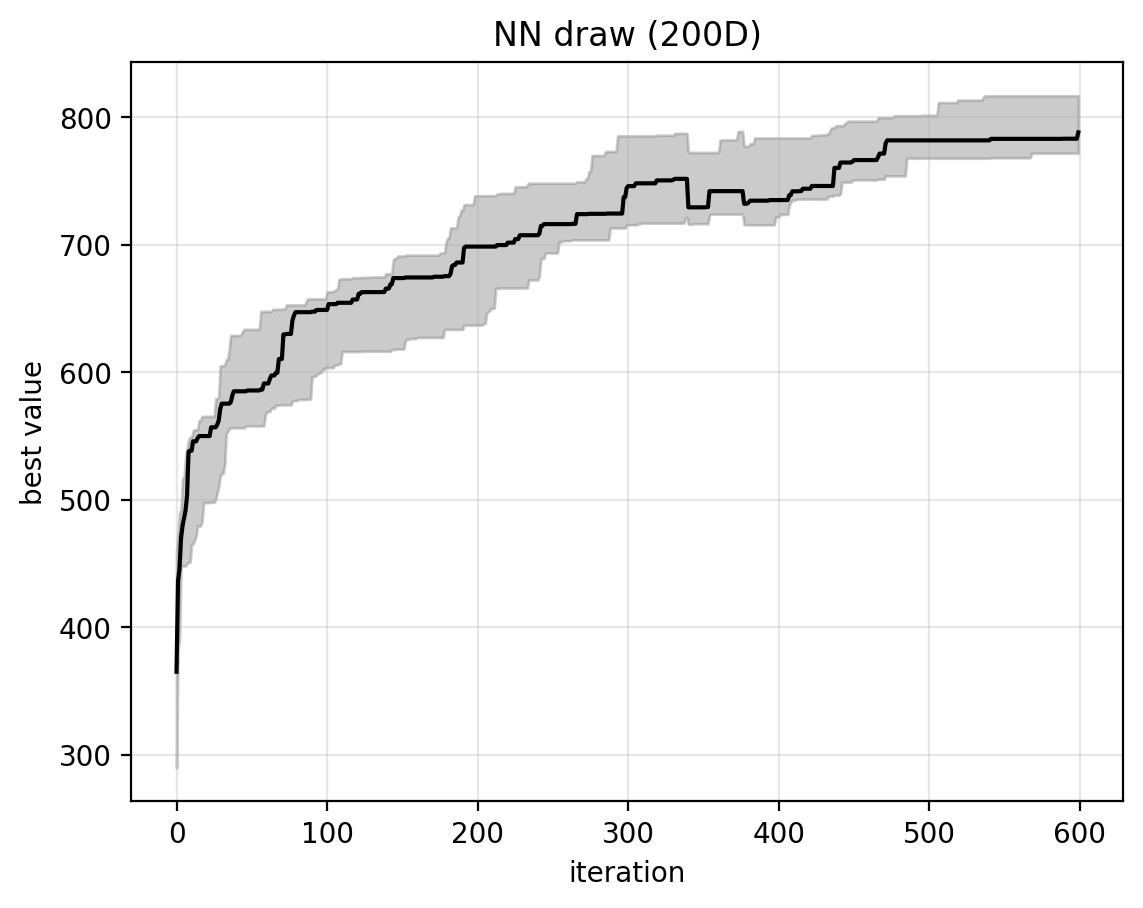

In [393]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Comparison

In [283]:
colors = sns.color_palette()

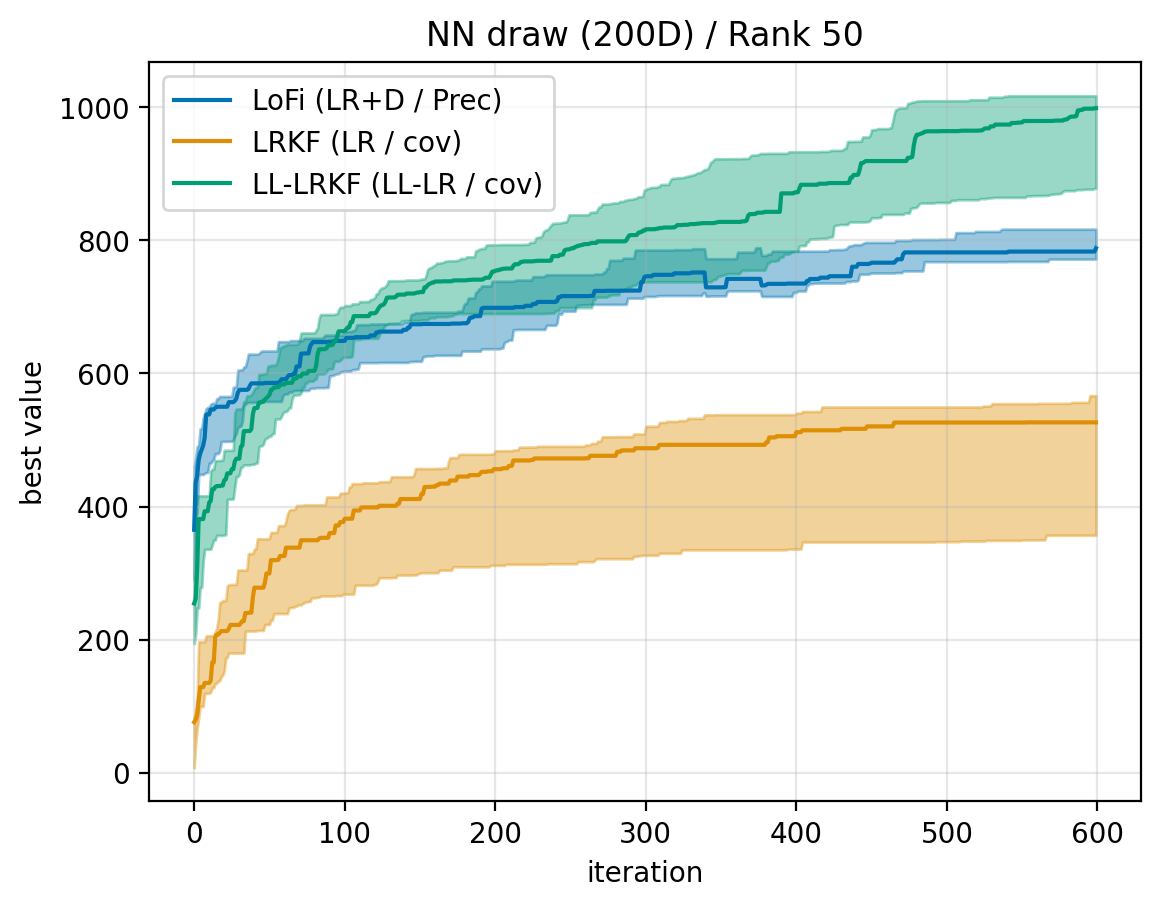

In [537]:
fig, ax = plt.subplots()
plot_hist(ax, runs["y_best"], label="LoFi (LR+D / Prec)", color=colors[0])
plot_hist(ax, runs_lrkf["y_best"], label="LRKF (LR / cov)",  color=colors[1])
plot_hist(ax, runs_l3rkf["y_best"], label="LL-LRKF (LL-LR / cov)",  color=colors[2])
plt.title(f"NN draw ({dim}D) / Rank {rank}")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend()
plt.grid(alpha=0.3)